# PiSTOL vs ASGD algorithms

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.io
from scipy.optimize import fmin_l_bfgs_b
from time import time
import sys as sys
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit
import os 
os.chdir('C:/Users/robin/Documents/Documents_importants/scolarité/ENSAE3A_DataScience/MasterDS/Semestre 2/optimisation/TPs/TP1')
import pandas as pd

In [3]:
# Fix random seed
np.random.seed(94)

# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 18
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True}
plt.rcParams.update(params)
plt.rc('font', family='Times New Roman')

In [4]:
# Load data
mat = scipy.io.loadmat('data_orsay_2017.mat')

In [5]:
# Put data in correct format 
X_test = mat['Xtest']
Y_test = mat['ytest']
X_train = mat['Xtrain']
Y_train = mat['ytrain']

In [14]:
nb_obs = X_train.shape[0]

## ASGD implementation 

In [6]:
def rate_1_sqrtn(n):
    ''' Step size function'''
    return (1/np.sqrt(n))

def quad_loss_sgd(theta,y,x):
    ''' Returns the quadratic loss'''
    return .5*np.mean((y-np.dot(x,theta.reshape(-1,1)))**2)

def grad_quad_loss_sgd(theta,y,x):
    ''' Returns the gradient of the quadratic loss  '''
    return np.mean(-x*(y-np.dot(x,theta.reshape(-1,1))),axis=0)

In [9]:
def sgd(theta_init, y, x, grad, n_iter, step, store_every=1, avg=False, cyclic=False):
    """Gradient descent algorithm."""
    theta = theta_init.copy()
    theta_avg = 0
    theta_list = []
    n = x.shape[0]

    for j in range(1,n_iter+1):
        chosen_idx = np.random.choice(n) if cyclic==False else (j-1)%n
        theta = theta - step(j) * grad(theta, y[chosen_idx],x[chosen_idx,:])
        if avg:
            theta_avg = (1-1/j)*theta_avg + (1/j)*theta
        if j % store_every == 0:
            if avg:
                theta_list.append(theta_avg.copy())
            else:
                theta_list.append(theta.copy())
    return (theta, theta_list) 

In [10]:
step = rate_1_sqrtn

theta_init = np.full(100,0)
estimates_avg = sgd(theta_init,Y_train,X_train,grad_quad_loss_sgd,n_iter=nb_obs,step=rate_1_sqrtn,store_every=1,avg=True)[1]

In [11]:
test_error_sgd_avg = []
for coef in estimates_avg:
    test_error_sgd_avg.append(quad_loss_sgd(coef, Y_test, X_test))

## PiSTOL implementation 

In [24]:
def quad_loss(y,y_pred):
    return np.mean((y-y_pred)**2,axis=0) 

def grad_quad_loss(y,y_pred):
    return np.mean(y-y_pred,axis=0) 

In [12]:
def gaussian_kernel(x, y, gamma=0.04):
    ''' Compute K '''
    return np.exp(-gamma*np.linalg.norm(x-y)**2)

In [13]:
def compute_kernel(X):
    ''' compute k(.,.) for each of the n observations
    Taken from mblondel's Github (percepetron repo)'''
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i,j] = gaussian_kernel(X[i], X[j])
    return K 

In [15]:
kernel = compute_kernel(X_train[:nb_obs,:])

In [16]:
def pistol(y, x, grad, n_iter, L, mu=0, store_every=1, b=1):
    """Gradient descent algorithm."""
    n, d = x.shape
    a = 0.25
    beta = np.sqrt(2*a*L*n) # Make only one pass over the data
    alpha = a*L
    
    f = np.zeros((n_iter,n))
    g = np.zeros((n_iter, n))
    
    for t in range(1, n_iter):

        f[t] = g[t-1]*(b/alpha)*np.exp(gaussian_kernel(g[t-1], np.zeros(n))**2/(2*alpha)) 
        y_pred = f[t,t%n] # f[t,t%n] might me better
                
        s_t =  grad(y_pred, y[t])
        # Updates
        g[t] = g[t-1] - s_t*kernel[t]
        alpha = alpha + a*np.abs(s_t)*gaussian_kernel(kernel[t], np.zeros(n)) 
    return f#np.mean(f,axis=0)

In [20]:
# Running the algorithm
n_iter = nb_obs
f_history = pistol(Y_train[:nb_obs], X_train[:nb_obs], grad=grad_quad_loss, n_iter=n_iter, L=5)

In [21]:
# Computing all the history of the predictions
pistol_history = []
for i in range(n_iter):
    pistol_history.append(np.mean(f_history[:i,:],axis=0))
pistol_history = np.nan_to_num(pistol_history)
pistol_history[pistol_history==0] = 5 # Initiate the first predictions as positive predictions (g_0=0 give no sign and generates nan...) 

C:\Users\robin\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\robin\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [25]:
# Converting the predictions for classification
preds_history = np.sign(pistol_history)
test_error_pistol = []
for i in range(n_iter):
    test_error_pistol.append(quad_loss(preds_history[i,:],Y_train[:nb_obs].flatten()))

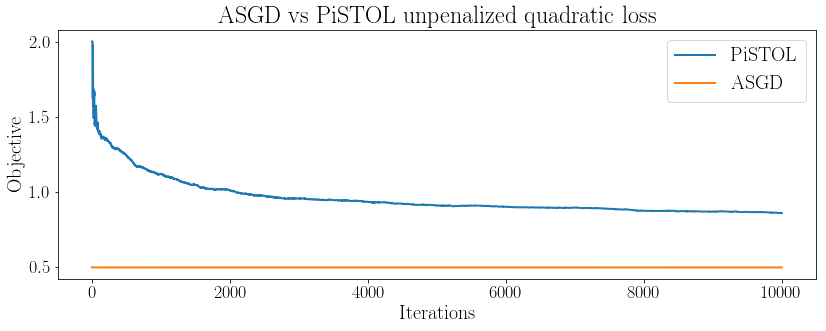

In [26]:
plt.figure(figsize=(12,5))
plt.plot(test_error_pistol, lw=2)
plt.plot(test_error_sgd_avg, lw=2)
plt.title("ASGD vs PiSTOL unpenalized quadratic loss")
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.legend(["PiSTOL", "ASGD"])
plt.tight_layout()
#plt.savefig('comp_asgd_pistol.png', format='png', dpi=300)